# Explore Ephys Sessions, Experiments and Conditions in the DataJoint Workflow


This notebook aims to explore various queries related to organoid IDs, experiment times, and drug applications using the pipeline. New cells can be added to examine each table's dependencies and attributes.

**_Note:_**

- The examples in this notebook use a sample dataset. Replace these entries with your actual database entries to access and analyze your data.



### **Key Steps**

- **Setup**

- **Step 1: Querying Ephys Sessions as Batches per Conditions**

    - **1.1. Selection of Keys for One Organoid Under Different Conditions and for a Specific Duration**

    - **1.2: Query for All Organoids Under Different Conditions**

    - **1.3: Queries for Batches Under Various Conditions with Example**

- **Step 2: Fetching the corresponding Intan Files for an Ephys Session**


#### **Setup**


First, import the necessary packages for the data pipeline and essential schemas.


In [1]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [2]:
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [3]:
from workflow.pipeline import culture, ephys

[2024-07-25 17:07:15,994][INFO]: Connecting milagros@db.datajoint.com:3306
[2024-07-25 17:07:17,777][INFO]: Connected milagros@db.datajoint.com:3306


#### **Step 1: Querying Ephys Sessions as Batches per Conditions**

##### **1.1: Select Keys for One Organoid Under Different Conditions and for a Specific Duration**


The `Experiment` table contains manually inserted data on experiments conducted on each organoid under various drug conditions. This table serves as a reference of experiment start and end times for each condition.

Let's have a look at the different conditions and experiment times for organoid `O09`:

In [4]:
exp_query = (culture.Experiment & 'organoid_id="O09"').proj(
    "experiment_end_time",
    "drug_name",
    "experiment_plan",
)
exp_query

organoid_id e.g. O17,experiment_start_time,experiment_end_time,drug_name,"experiment_plan e.g. mrna lysate, oct, protein lysate, or matrigel embedding, ephys, tracing"
O09,2023-05-03 17:33:00,2023-05-18 12:15:00,Control,ephys
O09,2023-05-18 12:25:00,2023-05-18 18:15:00,4-AP,ephys
O09,2023-05-18 18:15:00,2023-05-19 09:30:00,No Drug,ephys
O09,2023-05-19 09:30:00,2023-05-19 15:35:00,Bicuculline,ephys
O09,2023-05-19 15:45:00,2023-05-20 15:40:00,Tetrodotoxin,ephys


The specific ephys sessions are defined in the `EphysSession` table as `session_type="spike_sorting"`.

In [123]:
# Let's query the spike sorting sessions
session_type = "spike_sorting"
organoid_id = "O09"

In [124]:
ephys.EphysSession & {"session_type": session_type, "organoid_id": organoid_id}

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,session_type
O09,2023-05-03 17:33:00,0,2023-05-03 17:38:00,2023-05-03 17:53:00,spike_sorting
O09,2023-05-03 17:33:00,0,2023-05-18 11:55:00,2023-05-18 12:10:00,spike_sorting
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:26:30,spike_sorting
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,spike_sorting
O09,2023-05-18 12:25:00,0,2023-05-18 12:26:00,2023-05-18 12:31:00,spike_sorting
O09,2023-05-18 12:25:00,0,2023-05-18 12:27:00,2023-05-18 12:32:00,spike_sorting
O09,2023-05-18 12:25:00,0,2023-05-18 12:30:00,2023-05-18 12:45:00,spike_sorting
O09,2023-05-18 12:25:00,0,2023-05-18 12:34:00,2023-05-18 12:39:00,spike_sorting
O09,2023-05-18 12:25:00,0,2023-05-18 12:45:00,2023-05-18 12:50:00,spike_sorting
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,spike_sorting


Also, we want to **select** from a set of sessions that have the same **ephys duration**, in this case, **15min**, using the `proj` function:

In [125]:
ephys_query = (
    culture.Experiment * ephys.EphysSession
    & {"session_type": session_type, "organoid_id": organoid_id}
).proj(
    experiment_end_time="experiment_end_time",
    drug_name="drug_name",
    duration=f"TIMEDIFF(end_time, start_time)",
)
ephys_query

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,experiment_end_time,drug_name,duration calculated attribute
O09,2023-05-03 17:33:00,0,2023-05-03 17:38:00,2023-05-03 17:53:00,2023-05-18 12:15:00,Control,0:15:00
O09,2023-05-03 17:33:00,0,2023-05-18 11:55:00,2023-05-18 12:10:00,2023-05-18 12:15:00,Control,0:15:00
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:26:30,2023-05-18 18:15:00,4-AP,0:01:30
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,2023-05-18 18:15:00,4-AP,0:05:00
O09,2023-05-18 12:25:00,0,2023-05-18 12:26:00,2023-05-18 12:31:00,2023-05-18 18:15:00,4-AP,0:05:00
O09,2023-05-18 12:25:00,0,2023-05-18 12:27:00,2023-05-18 12:32:00,2023-05-18 18:15:00,4-AP,0:05:00
O09,2023-05-18 12:25:00,0,2023-05-18 12:30:00,2023-05-18 12:45:00,2023-05-18 18:15:00,4-AP,0:15:00
O09,2023-05-18 12:25:00,0,2023-05-18 12:34:00,2023-05-18 12:39:00,2023-05-18 18:15:00,4-AP,0:05:00
O09,2023-05-18 12:25:00,0,2023-05-18 12:45:00,2023-05-18 12:50:00,2023-05-18 18:15:00,4-AP,0:05:00
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,2023-05-18 18:15:00,4-AP,0:05:00


In [126]:
# Now let's query by 15min duration to easily identify one session example per condition by eye
dur = "0:15:00"  # 15 min

dur_15min_query = ephys_query & f"duration LIKE '%{dur}%'"
dur_15min_query

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,experiment_end_time,drug_name,duration calculated attribute
O09,2023-05-03 17:33:00,0,2023-05-03 17:38:00,2023-05-03 17:53:00,2023-05-18 12:15:00,Control,0:15:00
O09,2023-05-03 17:33:00,0,2023-05-18 11:55:00,2023-05-18 12:10:00,2023-05-18 12:15:00,Control,0:15:00
O09,2023-05-18 12:25:00,0,2023-05-18 12:30:00,2023-05-18 12:45:00,2023-05-18 18:15:00,4-AP,0:15:00
O09,2023-05-18 12:25:00,0,2023-05-18 17:55:00,2023-05-18 18:10:00,2023-05-18 18:15:00,4-AP,0:15:00
O09,2023-05-18 18:15:00,0,2023-05-19 09:10:00,2023-05-19 09:25:00,2023-05-19 09:30:00,No Drug,0:15:00
O09,2023-05-19 09:30:00,0,2023-05-19 09:35:00,2023-05-19 09:50:00,2023-05-19 15:35:00,Bicuculline,0:15:00
O09,2023-05-19 09:30:00,0,2023-05-19 15:15:00,2023-05-19 15:30:00,2023-05-19 15:35:00,Bicuculline,0:15:00
O09,2023-05-19 15:45:00,0,2023-05-19 15:50:00,2023-05-19 16:05:00,2023-05-20 15:40:00,Tetrodotoxin,0:15:00
O09,2023-05-19 15:45:00,0,2023-05-20 15:20:00,2023-05-20 15:35:00,2023-05-20 15:40:00,Tetrodotoxin,0:15:00


In [127]:
# From the table above, select one session per condition as an example and by their `start_time` here

selected_start_times = [
    "2023-05-18 11:55:00",  # control
    "2023-05-18 12:30:00",  # 4-AP
    "2023-05-19 09:10:00",  # No Drug
    "2023-05-19 15:15:00",  # Bicuculline
    "2023-05-19 15:50:00",  # Tetrodotoxin
]
selected_start_times_str = ", ".join([f"'{time}'" for time in selected_start_times])

Now, it is straightforward to query the session keys for each of the drug conditions:

In [128]:
selected_sessions_query = (
    dur_15min_query & f"start_time IN ({selected_start_times_str})"
)
selected_sessions_query

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,experiment_end_time,drug_name,duration calculated attribute
O09,2023-05-03 17:33:00,0,2023-05-18 11:55:00,2023-05-18 12:10:00,2023-05-18 12:15:00,Control,0:15:00
O09,2023-05-18 12:25:00,0,2023-05-18 12:30:00,2023-05-18 12:45:00,2023-05-18 18:15:00,4-AP,0:15:00
O09,2023-05-18 18:15:00,0,2023-05-19 09:10:00,2023-05-19 09:25:00,2023-05-19 09:30:00,No Drug,0:15:00
O09,2023-05-19 09:30:00,0,2023-05-19 15:15:00,2023-05-19 15:30:00,2023-05-19 15:35:00,Bicuculline,0:15:00
O09,2023-05-19 15:45:00,0,2023-05-19 15:50:00,2023-05-19 16:05:00,2023-05-20 15:40:00,Tetrodotoxin,0:15:00


##### **1.2: Example Keys for the Remaining Organoids Under Different Conditions**

In [138]:
# Fetch unique organoid IDs
organoid_ids = np.unique(culture.Experiment.fetch("organoid_id"))

# Create a string of organoid IDs for SQL query
organoid_ids_str = ", ".join(f"'{organoid_id}'" for organoid_id in organoid_ids)

# Build a query for sessions with a 15-minute duration
sessions_query = (
    (culture.Experiment * ephys.EphysSession)
    & f"session_type='spike_sorting'"
    & f"TIMESTAMPDIFF(MINUTE, start_time, end_time) = 15"
    & f"organoid_id IN ({organoid_ids_str})"
).proj(
    experiment_end_time="experiment_end_time",
    drug_name="drug_name",
    duration="TIMESTAMPDIFF(MINUTE, start_time, end_time)",
    organoid_id="organoid_id",
    start_time="start_time",
)

sessions_query

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,experiment_end_time,drug_name,duration calculated attribute
O09,2023-05-03 17:33:00,0,2023-05-03 17:38:00,2023-05-03 17:53:00,2023-05-18 12:15:00,Control,15
O09,2023-05-03 17:33:00,0,2023-05-18 11:55:00,2023-05-18 12:10:00,2023-05-18 12:15:00,Control,15
O09,2023-05-18 12:25:00,0,2023-05-18 12:30:00,2023-05-18 12:45:00,2023-05-18 18:15:00,4-AP,15
O09,2023-05-18 12:25:00,0,2023-05-18 17:55:00,2023-05-18 18:10:00,2023-05-18 18:15:00,4-AP,15
O09,2023-05-18 18:15:00,0,2023-05-19 09:10:00,2023-05-19 09:25:00,2023-05-19 09:30:00,No Drug,15
O09,2023-05-19 09:30:00,0,2023-05-19 09:35:00,2023-05-19 09:50:00,2023-05-19 15:35:00,Bicuculline,15
O09,2023-05-19 09:30:00,0,2023-05-19 15:15:00,2023-05-19 15:30:00,2023-05-19 15:35:00,Bicuculline,15
O09,2023-05-19 15:45:00,0,2023-05-19 15:50:00,2023-05-19 16:05:00,2023-05-20 15:40:00,Tetrodotoxin,15
O09,2023-05-19 15:45:00,0,2023-05-20 15:20:00,2023-05-20 15:35:00,2023-05-20 15:40:00,Tetrodotoxin,15
O10,2023-05-03 17:33:00,0,2023-05-03 17:38:00,2023-05-03 17:53:00,2023-05-18 12:15:00,Control,15


In [141]:
# Function to select one session per `drug_name` for each `organoid_id`
def select_one_session_per_drug(query):
    results = query.fetch(as_dict=True)

    # Initialize a list to hold the selected keys
    selected_keys = []

    # Iterate through each `organoid_id`
    for organoid_id in np.unique([r["organoid_id"] for r in results]):
        organoid_sessions = [r for r in results if r["organoid_id"] == organoid_id]

        # Group sessions by drug_name and select one per `drug_name`
        drug_names = np.unique([r["drug_name"] for r in organoid_sessions])
        for drug_name in drug_names:
            sessions_for_drug = [
                r for r in organoid_sessions if r["drug_name"] == drug_name
            ]
            if (
                sessions_for_drug
            ):  # Select the first session for each drug (this is as an example here and this logic can me modified based on your needs)
                selected_keys.append(sessions_for_drug[0])

    # Construct a query to filter the selected sessions
    filter_conditions = []
    for key in selected_keys:
        filter_conditions.append(
            f"(organoid_id = '{key['organoid_id']}' AND drug_name = '{key['drug_name']}' AND start_time = '{key['start_time']}')"
        )

    filter_condition_str = " OR ".join(filter_conditions)

    return query & f"({filter_condition_str})"


# Apply the selection function to the sessions_query
final_query = select_one_session_per_drug(sessions_query)
final_query

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,experiment_end_time,drug_name,duration calculated attribute
O09,2023-05-03 17:33:00,0,2023-05-03 17:38:00,2023-05-03 17:53:00,2023-05-18 12:15:00,Control,15
O09,2023-05-18 12:25:00,0,2023-05-18 12:30:00,2023-05-18 12:45:00,2023-05-18 18:15:00,4-AP,15
O09,2023-05-18 18:15:00,0,2023-05-19 09:10:00,2023-05-19 09:25:00,2023-05-19 09:30:00,No Drug,15
O09,2023-05-19 09:30:00,0,2023-05-19 09:35:00,2023-05-19 09:50:00,2023-05-19 15:35:00,Bicuculline,15
O09,2023-05-19 15:45:00,0,2023-05-19 15:50:00,2023-05-19 16:05:00,2023-05-20 15:40:00,Tetrodotoxin,15
O10,2023-05-03 17:33:00,0,2023-05-03 17:38:00,2023-05-03 17:53:00,2023-05-18 12:15:00,Control,15
O10,2023-05-18 12:25:00,0,2023-05-18 12:30:00,2023-05-18 12:45:00,2023-05-18 18:15:00,4-AP,15
O10,2023-05-18 18:15:00,0,2023-05-19 09:10:00,2023-05-19 09:25:00,2023-05-19 09:30:00,No Drug,15
O10,2023-05-19 09:30:00,0,2023-05-19 09:35:00,2023-05-19 09:50:00,2023-05-19 15:35:00,Bicuculline,15
O10,2023-05-19 15:45:00,0,2023-05-19 15:50:00,2023-05-19 16:05:00,2023-05-20 15:40:00,Tetrodotoxin,15


##### **1.3: Queries for Batches Under Various Conditions with Example**

In [142]:
batch1 = "'O09', 'O10', 'O11', 'O12'"
batch2 = "'O13', 'O14', 'O15', 'O16'"
batch3 = "'O17', 'O18', 'O19', 'O20'"

In [143]:
# query for batch 1
batch1_query = final_query & f"organoid_id IN ({batch1})"
batch1_query

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,experiment_end_time,drug_name,duration calculated attribute
O09,2023-05-03 17:33:00,0,2023-05-03 17:38:00,2023-05-03 17:53:00,2023-05-18 12:15:00,Control,15
O09,2023-05-18 12:25:00,0,2023-05-18 12:30:00,2023-05-18 12:45:00,2023-05-18 18:15:00,4-AP,15
O09,2023-05-18 18:15:00,0,2023-05-19 09:10:00,2023-05-19 09:25:00,2023-05-19 09:30:00,No Drug,15
O09,2023-05-19 09:30:00,0,2023-05-19 09:35:00,2023-05-19 09:50:00,2023-05-19 15:35:00,Bicuculline,15
O09,2023-05-19 15:45:00,0,2023-05-19 15:50:00,2023-05-19 16:05:00,2023-05-20 15:40:00,Tetrodotoxin,15
O10,2023-05-03 17:33:00,0,2023-05-03 17:38:00,2023-05-03 17:53:00,2023-05-18 12:15:00,Control,15
O10,2023-05-18 12:25:00,0,2023-05-18 12:30:00,2023-05-18 12:45:00,2023-05-18 18:15:00,4-AP,15
O10,2023-05-18 18:15:00,0,2023-05-19 09:10:00,2023-05-19 09:25:00,2023-05-19 09:30:00,No Drug,15
O10,2023-05-19 09:30:00,0,2023-05-19 09:35:00,2023-05-19 09:50:00,2023-05-19 15:35:00,Bicuculline,15
O10,2023-05-19 15:45:00,0,2023-05-19 15:50:00,2023-05-19 16:05:00,2023-05-20 15:40:00,Tetrodotoxin,15


In [144]:
# query for batch 2
batch2_query = final_query & f"organoid_id IN ({batch2})"
batch2_query

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,experiment_end_time,drug_name,duration calculated attribute
O13,2023-05-25 19:18:00,0,2023-05-25 19:23:00,2023-05-25 19:38:00,2023-06-08 18:55:00,Control,15
O13,2023-06-08 19:05:00,0,2023-06-08 19:10:00,2023-06-08 19:25:00,2023-06-08 23:35:00,4-AP,15
O13,2023-06-08 23:35:00,0,2023-06-09 10:00:00,2023-06-09 10:15:00,2023-06-09 10:20:00,No Drug,15
O13,2023-06-09 10:20:00,0,2023-06-09 10:25:00,2023-06-09 10:40:00,2023-06-09 15:35:00,Bicuculline,15
O13,2023-06-09 15:40:00,0,2023-06-09 15:45:00,2023-06-09 16:00:00,2023-06-10 14:15:00,Tetrodotoxin,15
O14,2023-05-25 19:18:00,0,2023-05-25 19:23:00,2023-05-25 19:38:00,2023-06-08 18:55:00,Control,15
O14,2023-06-08 19:05:00,0,2023-06-08 19:10:00,2023-06-08 19:25:00,2023-06-08 23:35:00,4-AP,15
O14,2023-06-08 23:35:00,0,2023-06-09 10:00:00,2023-06-09 10:15:00,2023-06-09 10:20:00,No Drug,15
O14,2023-06-09 10:20:00,0,2023-06-09 10:25:00,2023-06-09 10:40:00,2023-06-09 15:35:00,Bicuculline,15
O14,2023-06-09 15:40:00,0,2023-06-09 15:45:00,2023-06-09 16:00:00,2023-06-10 14:15:00,Tetrodotoxin,15


In [145]:
# query for batch 3
batch3_query = final_query & f"organoid_id IN ({batch3})"
batch3_query

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,experiment_end_time,drug_name,duration calculated attribute
O17,2023-06-22 15:40:00,0,2023-06-22 15:45:00,2023-06-22 16:00:00,2023-07-12 13:00:00,Control,15
O17,2023-07-12 13:10:00,0,2023-07-12 13:15:00,2023-07-12 13:30:00,2023-07-12 16:10:00,4-AP,15
O17,2023-07-12 16:10:00,0,2023-07-13 12:15:00,2023-07-13 12:30:00,2023-07-13 12:35:00,No Drug,15
O17,2023-07-13 12:35:00,0,2023-07-13 12:40:00,2023-07-13 12:55:00,2023-07-13 18:10:00,Bicuculline,15
O17,2023-07-13 18:15:00,0,2023-07-13 18:20:00,2023-07-13 18:35:00,2023-07-14 15:45:00,Tetrodotoxin,15
O18,2023-06-22 15:40:00,0,2023-06-22 15:45:00,2023-06-22 16:00:00,2023-07-12 13:00:00,Control,15
O18,2023-07-12 13:10:00,0,2023-07-12 13:15:00,2023-07-12 13:30:00,2023-07-12 16:10:00,4-AP,15
O18,2023-07-12 16:10:00,0,2023-07-13 12:15:00,2023-07-13 12:30:00,2023-07-13 12:35:00,No Drug,15
O18,2023-07-13 12:35:00,0,2023-07-13 12:40:00,2023-07-13 12:55:00,2023-07-13 18:10:00,Bicuculline,15
O18,2023-07-13 18:15:00,0,2023-07-13 18:20:00,2023-07-13 18:35:00,2023-07-14 15:45:00,Tetrodotoxin,15


After establishing the queries, you can proceed with analyzing the results. For instance:

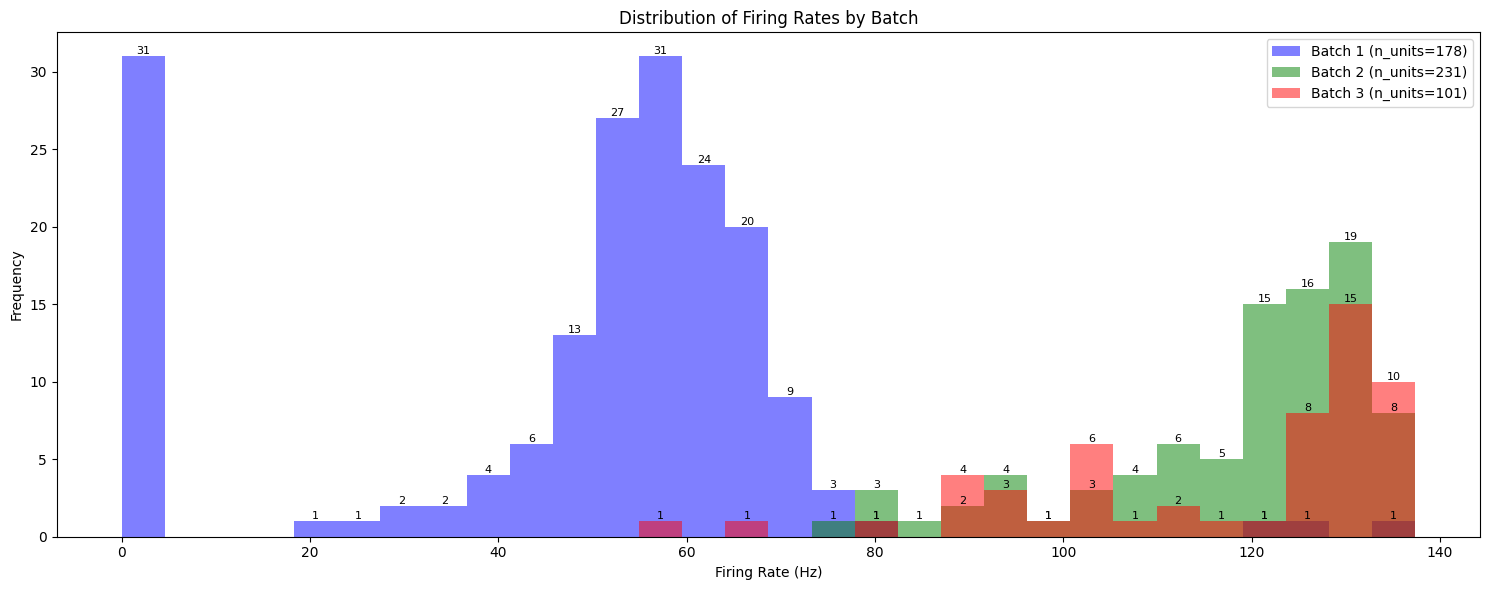

In [181]:
# Define batch queries and colors for plotting
batch_queries = {
    "Batch 1": batch1_query,
    "Batch 2": batch2_query,
    "Batch 3": batch3_query,
}

# Initialize dictionaries to store firing rates and batch sizes
firing_rates = {}
batch_sizes = {}

# Fetch firing rates and batch sizes for each batch
for label, query in batch_queries.items():
    batch_keys = query.fetch("KEY")
    firing_rates[label] = (ephys.QualityMetrics.Cluster & batch_keys).fetch(
        "firing_rate"
    )
    batch_sizes[label] = len(firing_rates[label])  # Store the number of units

# Plotting
fig, ax = plt.subplots(figsize=(15, 6))

# Define consistent number of bins
bins = 30

# Plot histograms for each batch with labels
colors = ["blue", "green", "red"]
for (label, rates), color in zip(firing_rates.items(), colors):
    n, bins, patches = ax.hist(
        rates,
        bins=bins,
        alpha=0.5,
        color=color,
        label=f"{label} (n_units={batch_sizes[label]})",
    )

    # Annotate the plot with the number of units for each batch
    for patch in patches:
        height = patch.get_height()
        if height > 0:
            x = patch.get_x() + patch.get_width() / 2
            y = height
            ax.text(x, y, f"{int(height)}", ha="center", va="bottom", fontsize=8)

# Adding titles and labels
ax.set_title("Distribution of Firing Rates by Batch")
ax.set_xlabel("Firing Rate (Hz)")
ax.set_ylabel("Frequency")
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

#### **Step 2: Fetching the Corresponding Intan Files for an Ephys Session**

In [182]:
key1 = {
    "organoid_id": "O15",
    "experiment_start_time": datetime.datetime(2023, 5, 25, 19, 18),
    "insertion_number": 0,
    "start_time": datetime.datetime(2023, 6, 8, 18, 35),
    "end_time": datetime.datetime(2023, 6, 8, 18, 50),
}
key1

{'organoid_id': 'O15',
 'experiment_start_time': datetime.datetime(2023, 5, 25, 19, 18),
 'insertion_number': 0,
 'start_time': datetime.datetime(2023, 6, 8, 18, 35),
 'end_time': datetime.datetime(2023, 6, 8, 18, 50)}

In [183]:
query = (
    culture.Experiment().proj("drug_name") * ephys.EphysSession
    & {"session_type": "spike_sorting"}
    & key1
)
query

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,drug_name,session_type
O15,2023-05-25 19:18:00,0,2023-06-08 18:35:00,2023-06-08 18:50:00,Control,spike_sorting


In [184]:
# These are the corresponding intan files for this session.

key = query.fetch1()
title = "_".join(
    [
        key["organoid_id"],
        key["start_time"].strftime("%Y%m%d%H%M"),
        key["end_time"].strftime("%Y%m%d%H%M"),
        key["drug_name"].replace(" ", ""),
    ]
)
files, file_times = (
    ephys.EphysRawFile
    & f"file_time BETWEEN '{key['start_time']}' AND '{key['end_time']}'"
).fetch("file_path", "file_time", order_by="file_time")

[print(file) for file in files]
print(f"\nNumber of files: {len(files)} ({key['drug_name']})")

O13-16_raw/processed_O13-16_230608_183542.rhd
O13-16_raw/processed_O13-16_230608_183642.rhd
O13-16_raw/processed_O13-16_230608_183742.rhd
O13-16_raw/processed_O13-16_230608_183842.rhd
O13-16_raw/processed_O13-16_230608_183942.rhd
O13-16_raw/processed_O13-16_230608_184042.rhd
O13-16_raw/processed_O13-16_230608_184142.rhd
O13-16_raw/processed_O13-16_230608_184242.rhd
O13-16_raw/processed_O13-16_230608_184342.rhd
O13-16_raw/processed_O13-16_230608_184442.rhd
O13-16_raw/processed_O13-16_230608_184542.rhd
O13-16_raw/processed_O13-16_230608_184642.rhd
O13-16_raw/processed_O13-16_230608_184742.rhd
O13-16_raw/processed_O13-16_230608_184842.rhd
O13-16_raw/processed_O13-16_230608_184942.rhd

Number of files: 15 (Control)
